# 13. Advanced segmentation

In [1]:
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.gray();

# generate random colormap
from course_functions import random_cmap
cmap = random_cmap();

<Figure size 640x480 with 0 Axes>

Until now we have seen classical image processing and in particular segmentation methods. Over the last decade new methods based on Machine Learning (ML) have emerged. Those methods are powerful but usually more difficult to use both on a hardware and software level. Additionally ML methods require a training step that requires annotated data that can be time-consuming to produce. However, recently solutions have emerged that offer pre-trained models with a broad applicability for cell and nucleus segmentation. We will briefly explore two of them.

If you intend to use ML methods we **strongly encourage** you to visit the great [ZeroCostDL4Mic](https://github.com/HenriquesLab/ZeroCostDL4Mic) project, which makes it easy to test various methods directly within Google Colab notebooks.

## 13.1 Stardist

[Stardist](https://github.com/mpicbg-csbd/stardist) is a segmentation tool able to separate even densely packed so-called star-convex objects (in summary, a line can be drawn within the object from the object "center" to all points on the boundary, see [here](https://en.wikipedia.org/wiki/Star_domain) for formal definition). A model pre-trained on a large collection of cell nuclei images of various sorts is directly available in this tool. However it can also be re-trained by the user. Our goal here is only to attract your attention to this software and give a very short intro to it. **For a full description, check the Github repository and the great examples provided as notebooks.**

We will try to segment an image using the pre-trained network. If the image features are close enough to those found in the training set, we should be able to obtain a reasonable results.

We start by importing the necessary components of stardist, in particular the ```model``` module and a pre-processing function ```normalize```:

In [2]:
# On Mac arm64 (M1, M2) as of July 17 2023, Tensorflow 2.13 generates an error. You need to revert back to 2.12:
# pip uninstall tensorflow
# pip uninstall tensorflow-mac
# pip install tensorflow-macos==2.12
# pip install tensorflow-metal==0.8.0

from stardist.models import StarDist2D
from csbdeep.utils import normalize

model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Metal device set to: Apple M1 Pro
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


We will try to segment an [image](http://cellimagelibrary.org/images/50658) containing nuclei found in the the Cell Image Library:

In [3]:
image = io.imread('../Data/Image6AltFinal.tif')

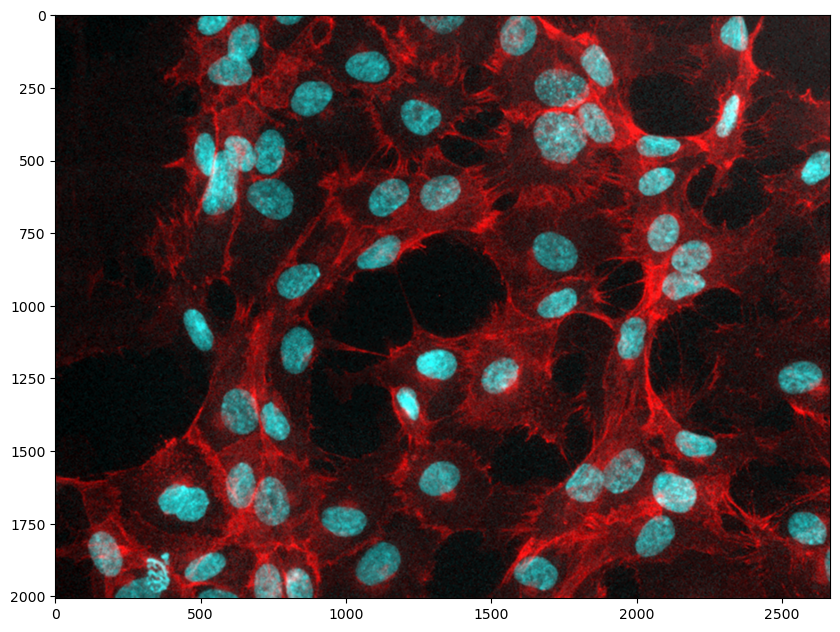

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(image[:,:]);

In order to be understood by the network, the intensity needs to be rescaled. We use here a function provided in Stardist:

In [5]:
image_norm = normalize(image[::1, ::1, 2], 1, 99.8)

Now we can use our model to predict labels for nuclei:

In [6]:
labels, details = model.predict_instances(image_norm)

2023-07-17 15:19:47.577517: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 1s 1s/step


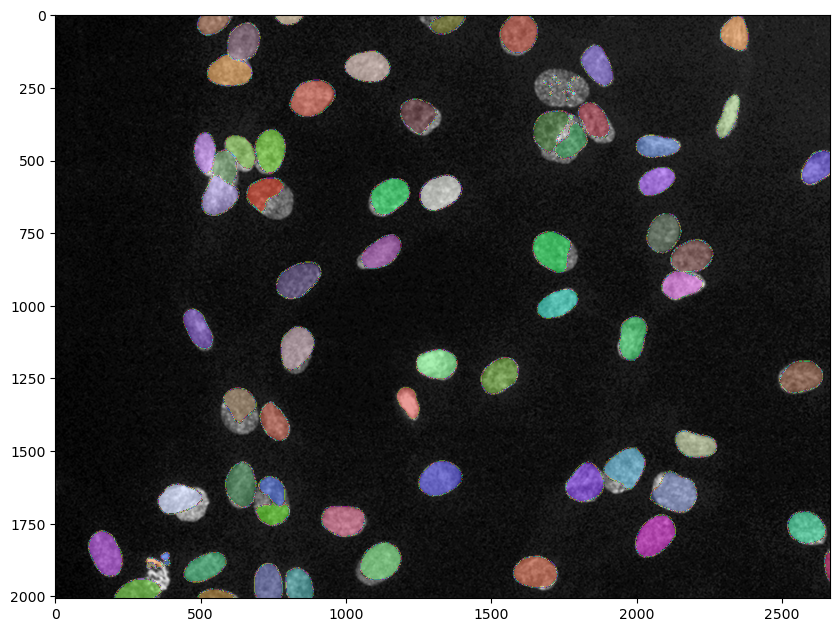

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(image[::1,::1,2])
plt.imshow(labels, cmap = cmap);

Clearly something went wrong here. All our nuclei are split up in multiple parts. Apparently the network was trained on images with smaller nuclei. We can try to rescale our image:

In [8]:
image_norm = normalize(image[::4,::4,2], 1, 99.8)
labels, details = model.predict_instances(image_norm)

1/1 [==============================] - 0s 290ms/step


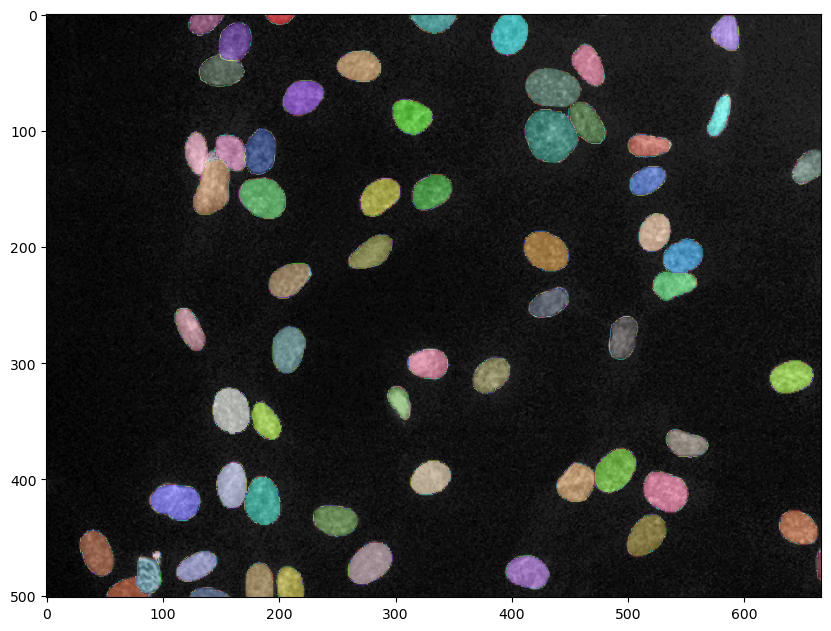

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(image[::4,::4,2])
plt.imshow(labels, cmap = cmap);

Now we have an almost perfect results, even nuclei that are close together and that might be difficult to separate otherwise are well-segmented. This short example illustrates how **one should be cautious when re-using a pre-trained network**. In any case, manually annotate a few examples and show that the automated segmentation matches your expectations.

## 13.2 Cellpose

Cellpose is a new algorithm whose goal is specifically to allow for an easy segmentation of nuclei and cell images. Just like Stardist, it mixes a conventional approach (here a diffusion based cell map) with deep learning to directly generate a label image. It has been trained on a very large dataset making it versatile but can always be further trained. You can test the software by drag and drop on a [website](http://www.cellpose.org/), install a local GUI or run it directly as a Python module as here.

First we need to import the necessara packages:

In [10]:
from cellpose import models

Then we need to instantiate a model. We can choose to either segment cells or nuclei by setting the ```model_type``` option. One can also choose the whether to use CPU or GPU:

In [11]:
model = models.Cellpose(model_type="nuclei")

Finally we can do the prediction. The synthax is a bit unusual here. We can in principle pass multiple images to the model as a list of images so here we enclose our image in brackets. Second you need to specify the ```channels``` option. This tells the model which channels to use in case one has multi-channel images for cells and nuclei. Here we have only a single channel image but still need to specify ```[0, 0]``` for the second potental channel.

Finally we can optionally specify an average diameter. Cellpose has the possibility to estimate the size of the objects, but it's much faster to use that option. To speed up things we use the same rescaled image as before and use 20px as our diameter estimate:

In [14]:
image.shape

(2007, 2667, 3)

In [15]:
masks, _, _, _ = model.eval(image[::4, ::4, 2], channels=[0,0], diameter=20)

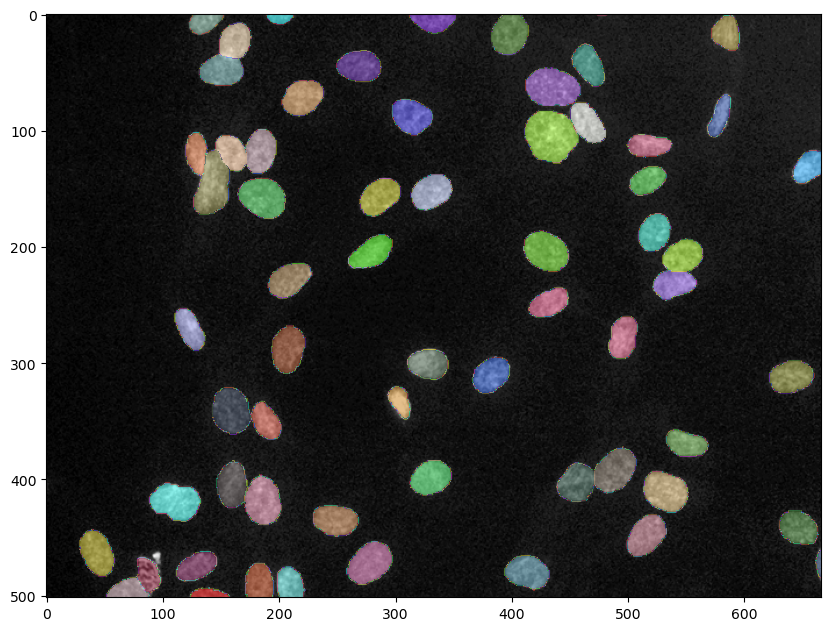

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(image[::4,::4, 2])
plt.imshow(masks, cmap = cmap);

We see that the result is excellent!